In [1]:
import os
from multiprocessing import Pool
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# **1. Data loading**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [3]:
data = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')
supplemental = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv')

supplemental['timestamp_dt'] = pd.to_datetime(supplemental['timestamp'], unit='s')
data['timestamp_dt'] = pd.to_datetime(data['timestamp'], unit='s')

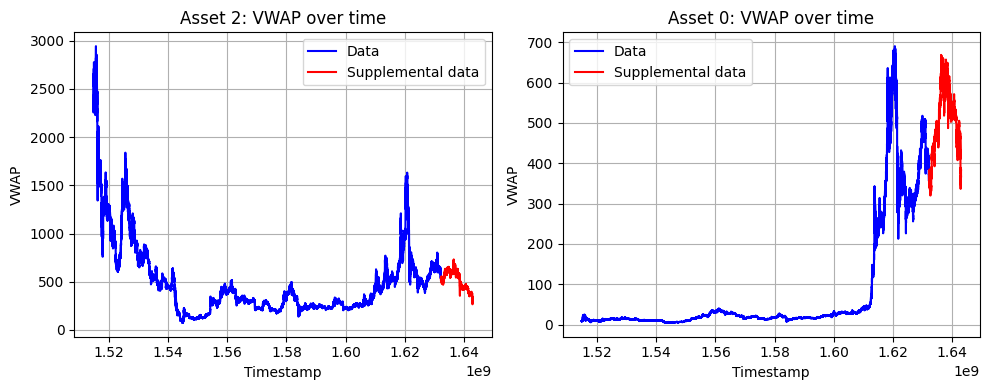

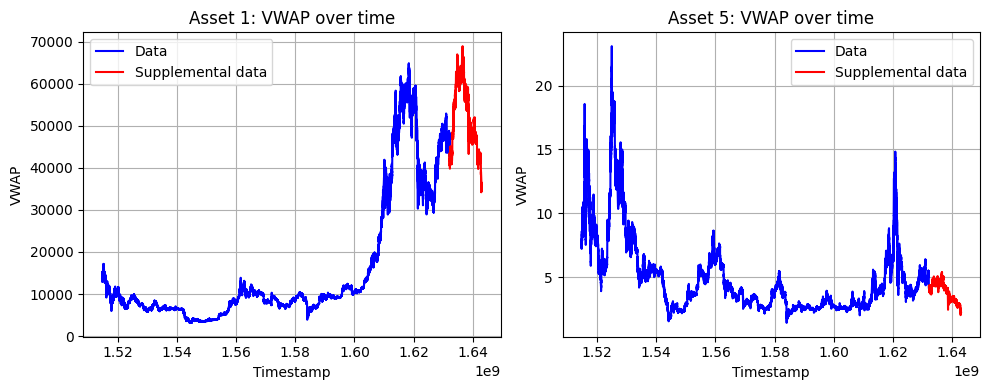

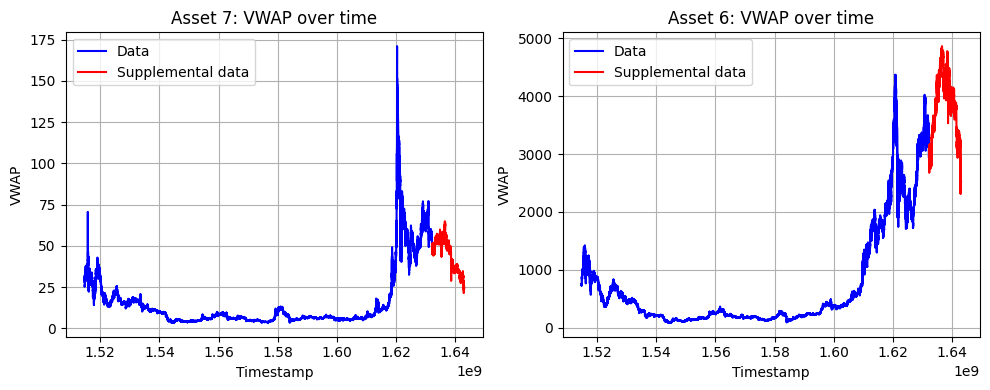

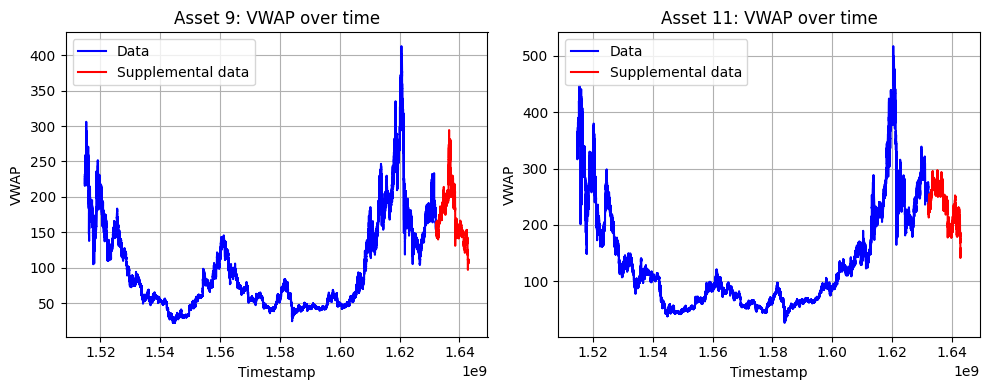

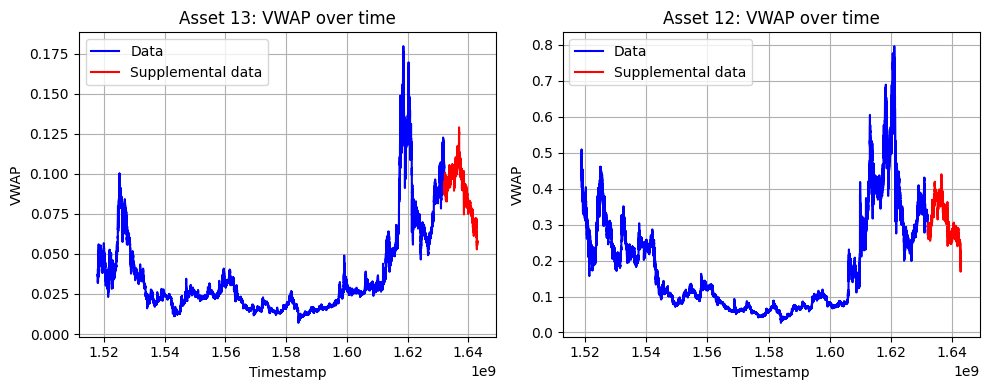

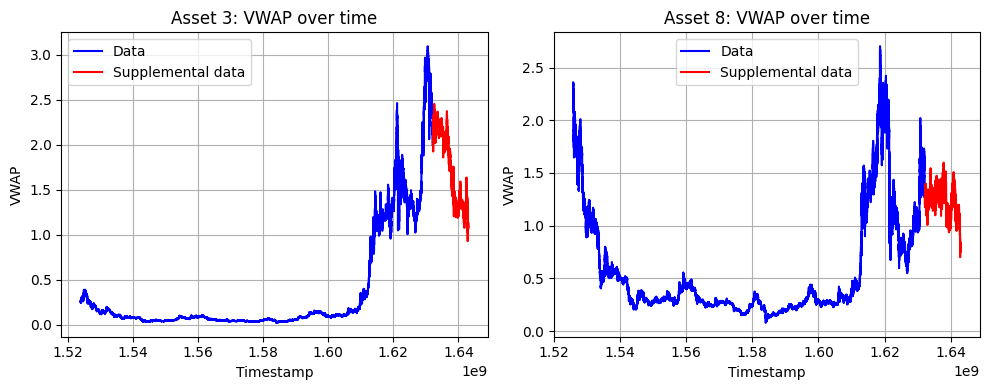

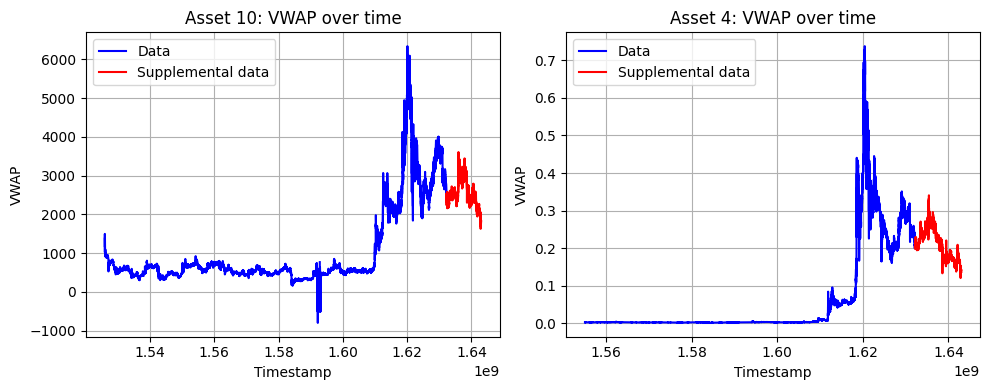

In [4]:
assets = data['Asset_ID'].unique().tolist()

n_plots = 2
for i in range(0, len(assets), n_plots):
    batch = assets[i:i+n_plots]
    fig, axes = plt.subplots(1, len(batch), figsize=(5*len(batch), 4))
    
    for ax, asset_id in zip(axes, batch):
        data_main = data[data['Asset_ID'] == asset_id].sort_values('timestamp')
        ax.plot(data_main['timestamp'], data_main['VWAP'], color='blue', label='Data')
        
        if 'Asset_ID' in supplemental.columns:
            data_supp = supplemental[supplemental['Asset_ID'] == asset_id].sort_values('timestamp')
            if not data_supp.empty:
                ax.plot(data_supp['timestamp'], data_supp['VWAP'], color='red', label='Supplemental data')
        
        ax.set_title(f'Asset {asset_id}: VWAP over time')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('VWAP')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
test = (supplemental.sort_values(["Asset_ID", "timestamp"]).reset_index(drop=True))
train = (data.sort_values(["Asset_ID", "timestamp"]).reset_index(drop=True))

# **2. Data preprocessing**

In [7]:
def make_regular_series(df_asset, asset, method='pad', col='timestamp'):
    """
    Function makes the time series regular by timestamp.
    df_asset — filtered DataFrame by Asset_ID 
    """
    df_asset = df_asset.set_index(col)
    
    min_time = df_asset.index.min()
    max_time = df_asset.index.max()
    
    df_asset = df_asset.reindex(
        range(min_time, max_time + 60, 60),
        method=method
    )
    
    return df_asset

assets = train['Asset_ID'].unique().tolist()
groups = {asset: train[train['Asset_ID'] == asset].copy() for asset in assets}

with Pool(3) as pool:
    results = pool.starmap(make_regular_series, [(groups[asset], asset) for asset in assets])

train_all_regular = pd.concat(results)

del results
del groups
gc.collect()


41409

In [8]:
# All fillings instead of 0 will provide leakage 
train_all_regular['Target'] = train_all_regular['Target'].fillna(0)


train_all_regular['VWAP'] = (
    train_all_regular['VWAP']
    .replace([np.inf, -np.inf], np.nan)  
    .ffill()                              
)

In [ ]:
keep_vars = ['train_all_regular'] 
for var in list(globals().keys()):
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

In [12]:
scalers = {}

features_to_mm_scale = ["Count", "Open", "High", "Low", "Close", "Volume", "VWAP"]

train_scaled_list = []

for asset in train["Asset_ID"].unique():
    df_a = train_all_regular.loc[train_all_regular.Asset_ID == asset, :].copy()
    scaler = MinMaxScaler()
    df_a[features_to_mm_scale] = scaler.fit_transform(df_a[features_to_mm_scale])
    scalers[asset] = scaler
    train_scaled_list.append(df_a)

train_min_max = pd.concat(train_scaled_list)


In [13]:
scalers_log = {}
scalers_rob = {}

features_to_log_scale = ['Volume', 'Count']
features_to_rob_scale = ["Open", "High", "Low", "Close", "VWAP"]

train_scaled_list = []

for asset in train_all_regular["Asset_ID"].unique():
    df_a = train_all_regular.loc[train_all_regular.Asset_ID == asset, :].copy()
    
    df_a[features_to_log_scale] = np.log1p(df_a[features_to_log_scale])
    scalers_log[asset] = "log1p"  # просто пометка, scaler не нужен
    
    scaler = RobustScaler()
    df_a[features_to_rob_scale] = scaler.fit_transform(df_a[features_to_rob_scale])
    scalers_rob[asset] = scaler
    
    train_scaled_list.append(df_a)

train_log_rob = pd.concat(train_scaled_list)

del train_scaled_list
gc.collect()

64

In [14]:
train_log_rob.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,timestamp_dt
timestamp,,,,,,,,,,
1514764860,0,1.791759,-0.539868,-0.540358,-0.539340,-0.539854,4.374246,-0.539865,-0.014399,2018-01-01 00:01:00
1514764920,0,2.079442,-0.539868,-0.540358,-0.540215,-0.540729,4.282068,-0.540417,-0.015875,2018-01-01 00:02:00
1514764980,0,3.828641,-0.541194,-0.540363,-0.541891,-0.542404,7.344603,-0.541478,-0.015410,2018-01-01 00:03:00
1514765040,0,2.708050,-0.541510,-0.541677,-0.542478,-0.541496,4.842611,-0.542696,-0.012524,2018-01-01 00:04:00
1514765100,0,1.791759,-0.541521,-0.542010,-0.543517,-0.544029,4.836361,-0.543902,-0.005940,2018-01-01 00:05:00


# **3. Baseline**

In [ ]:
# def weighted_pearson_cor():
# Linear regression
train_log_rob
train_min_max


# Multioutput linear regression


In [ ]:
# немного посложнее модель sarima какая-нибудь 

# **4. EDA**

In [ ]:
# здесь статистический, трендовый, экономический

In [ ]:
стационарность, автокорреляция

# **5. Feature engineering**

In [ ]:
# всякие статистические фичи
# от корреляции
корреляция монет по разным временным промежуткам
def cov():
    pass 
def weightcov():
    pass
def volatility():
    pass
def rollind_mean():
    pass
def std():
    pass
def ema():
    pass
def lags():
    pass
def log_return():
    pass
def season():
    pass
def times_of_day():
    pass
def derivative():
    pass
def trend():
    pass
def add_weight_asset():
    pass 
из таргета какие-то фичи доставать?

# **6. Feature selection**

In [ ]:
# корреляции ? heatmap

пайплайн для фичей

# **7. Model development**

In [ ]:
grid_params = {
    
}
Кастомные loss-функции (под корреляцию)
# Feature testing by linear ridge regression

# Then LightGBM and LSTM

# **8. Model selection**

# **9. Model quality assesment**

In [ ]:
#Сделать небольшой аналог итератора по тесту
# an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = 0  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions